<a href="https://colab.research.google.com/github/TanmoyGG/CVPR/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Imports and global settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make results reproducible
np.random.seed(42)



In [41]:
# Generate synthetic dataset (5 Gaussian clusters)

num_classes = 5
samples_per_class = 200   # total samples = 5 * 200 = 1000
input_dim = 2             # 2D features -> easy to visualize

# Define centers (means) for the 5 Gaussian clusters
means = np.array([
    [-4, -4],
    [-4,  4],
    [ 0,  0],
    [ 4,  4],
    [ 4, -4]
])

# Covariance: for simplicity we use isotropic Gaussians with same variance
std_dev = 1.0  # standard deviation for all clusters

X_list = []
y_list = []

for class_idx in range(num_classes):
    # Sample points for this class from a normal distribution
    class_samples = np.random.randn(samples_per_class, input_dim) * std_dev + means[class_idx]
    X_list.append(class_samples)
    y_list.append(np.full((samples_per_class,), class_idx, dtype=int))

# Stack all classes together
X = np.vstack(X_list)          # shape: (N, 2)
y = np.concatenate(y_list)     # shape: (N,)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# Shuffle the dataset so classes are mixed
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


Dataset shape: (1000, 2)
Labels shape: (1000,)


In [42]:
# Train/test split and one-hot encoding of labels
# Split into training (80%) and testing (20%)

train_ratio = 0.8
num_samples = X.shape[0]
train_size = int(train_ratio * num_samples)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)

# One-hot encoding for labels (required for softmax + cross-entropy)
def one_hot_encode(labels, num_classes):

    N = labels.shape[0]
    one_hot = np.zeros((N, num_classes))
    one_hot[np.arange(N), labels] = 1.0
    return one_hot

y_train_oh = one_hot_encode(y_train, num_classes)
y_test_oh = one_hot_encode(y_test, num_classes)

print("One-hot train labels shape:", y_train_oh.shape)


Train set: (800, 2) (800,)
Test set : (200, 2) (200,)
One-hot train labels shape: (800, 5)


In [43]:
# The Neural Network with 3 hidden layers

class NeuralNetwork(object):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim, learning_rate=0.01):
        # Network architecture
        self.input_dim = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.hidden3 = hidden3
        self.output_dim = output_dim

        self.learning_rate = learning_rate


        self.W1 = 0.1 * np.random.randn(self.input_dim, self.hidden1)
        self.b1 = np.zeros((1, self.hidden1))

        self.W2 = 0.1 * np.random.randn(self.hidden1, self.hidden2)
        self.b2 = np.zeros((1, self.hidden2))

        self.W3 = 0.1 * np.random.randn(self.hidden2, self.hidden3)
        self.b3 = np.zeros((1, self.hidden3))

        self.W4 = 0.1 * np.random.randn(self.hidden3, self.output_dim)
        self.b4 = np.zeros((1, self.output_dim))

    #Activation functions
    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, a):

        return (a > 0).astype(float)

    def softmax(self, z):
        """
        Stable softmax: subtract max for numerical stability.
        Input shape: (N, output_dim)
        Output shape: (N, output_dim)
        """
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_scores = np.exp(z_shift)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    # Forward pass
    def feed_forward(self, X):
        """
        Perform a full forward pass through the network.
        Stores intermediate activations for backpropagation.
        """
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1      # (N, hidden1)
        self.A1 = self.relu(self.Z1)                # (N, hidden1)

        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # (N, hidden2)
        self.A2 = self.relu(self.Z2)                  # (N, hidden2)

        # Layer 3
        self.Z3 = np.dot(self.A2, self.W3) + self.b3  # (N, hidden3)
        self.A3 = self.relu(self.Z3)                  # (N, hidden3)

        # Output layer
        self.Z4 = np.dot(self.A3, self.W4) + self.b4  # (N, output_dim)
        self.Y_hat = self.softmax(self.Z4)            # (N, output_dim)

        return self.Y_hat

    # Loss: Cross-Entropy
    def compute_loss(self, Y_true, Y_pred):
        """
        Multi-class cross-entropy loss:
        L = - (1/N) * sum_i sum_k y_ik * log(y_hat_ik)
        where Y_true and Y_pred are (N, num_classes)
        """
        eps = 1e-15  # small value to avoid log(0)
        N = Y_true.shape[0]
        log_probs = np.log(Y_pred + eps)
        loss = -np.sum(Y_true * log_probs) / N
        return loss

    # Backpropagation
    def back_propagation(self, X, Y_true):
        """
        Perform backpropagation and update the weights and biases.
        Y_true: one-hot encoded labels, shape (N, output_dim)
        """
        N = X.shape[0]

        dZ4 = (self.Y_hat - Y_true) / N  # (N, output_dim)

        # Gradients for W4 and b4
        dW4 = np.dot(self.A3.T, dZ4)               # (hidden3, output_dim)
        db4 = np.sum(dZ4, axis=0, keepdims=True)   # (1, output_dim)

        # Backprop to layer 3
        dA3 = np.dot(dZ4, self.W4.T)               # (N, hidden3)
        dZ3 = dA3 * self.relu_derivative(self.A3)  # (N, hidden3)
        dW3 = np.dot(self.A2.T, dZ3)               # (hidden2, hidden3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)   # (1, hidden3)

        # Backprop to layer 2
        dA2 = np.dot(dZ3, self.W3.T)               # (N, hidden2)
        dZ2 = dA2 * self.relu_derivative(self.A2)  # (N, hidden2)
        dW2 = np.dot(self.A1.T, dZ2)               # (hidden1, hidden2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)   # (1, hidden2)

        # Backprop to layer 1
        dA1 = np.dot(dZ2, self.W2.T)               # (N, hidden1)
        dZ1 = dA1 * self.relu_derivative(self.A1)  # (N, hidden1)
        dW1 = np.dot(X.T, dZ1)                     # (input_dim, hidden1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)   # (1, hidden1)

        # Gradient descent parameter update
        lr = self.learning_rate
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

        self.W3 -= lr * dW3
        self.b3 -= lr * db3

        self.W2 -= lr * dW2
        self.b2 -= lr * db2

        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    # Training helper
    def train(self, X, Y_true, num_epochs=2000, print_every=200):
        """
        Train the network for a given number of epochs.
        Returns the history of losses and accuracies.
        """
        loss_history = []
        acc_history = []

        for epoch in range(num_epochs):
            # Forward pass
            Y_pred = self.feed_forward(X)

            # Compute loss
            loss = self.compute_loss(Y_true, Y_pred)
            loss_history.append(loss)

            # Compute training accuracy
            y_pred_labels = np.argmax(Y_pred, axis=1)
            y_true_labels = np.argmax(Y_true, axis=1)
            accuracy = np.mean(y_pred_labels == y_true_labels)
            acc_history.append(accuracy)

            # Backprop and update
            self.back_propagation(X, Y_true)

            # Print progress
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

        return loss_history, acc_history

    # Prediction
    def predict_proba(self, X):
        """
        Return class probabilities for given inputs.
        """
        return self.feed_forward(X)

    def predict(self, X):
        """
        Return class labels for given inputs.
        """
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


# Documentation & Implementation Report

### 1. Modifications for Multi-Class Classification
To transition from the original binary classification (XOR problem) to a multi-class classification task with five classes, several fundamental structural changes were made to the `NeuralNetwork` class.

**A. Architecture Expansion (Deepening the Network)**
* **Original:** The base code used a shallow architecture: Input $\rightarrow$ Hidden $\rightarrow$ Output (2 layers).
* **Modification:** I expanded this to a deep architecture with **three hidden layers**. This involved initializing four distinct weight matrices (`W1`, `W2`, `W3`, `W4`) and their corresponding bias vectors (`b1`, `b2`, `b3`, `b4`).
    * `W1`: Connects Input $\rightarrow$ Hidden Layer 1
    * `W2`: Connects Hidden Layer 1 $\rightarrow$ Hidden Layer 2
    * `W3`: Connects Hidden Layer 2 $\rightarrow$ Hidden Layer 3
    * `W4`: Connects Hidden Layer 3 $\rightarrow$ Output Layer

**B. Output Layer Adjustment**
* **Original:** The output layer had `1` neuron (binary 0/1 output).
* **Modification:** The output layer size was increased to `5` neurons. Each neuron corresponds to the probability score for one of the five classes.

**C. Activation Function: Softmax**
* **Original:** Used `Sigmoid` activation at the output.
* **Modification:** I implemented the **Softmax** activation function for the final layer.
    * *Why:* Sigmoid pushes values to 0 or 1, which is independent for each neuron. Softmax normalizes the output vector into a probability distribution where the sum of all class probabilities equals 1.0. This is the standard for multi-class problems.
    * *Formula:* $Softmax(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$

**D. Loss Function: Categorical Cross-Entropy**
* **Original:** Used Mean Squared Error (MSE).
* **Modification:** I implemented **Categorical Cross-Entropy**.
    * *Why:* MSE is inefficient for classification as it penalizes errors linearly. Cross-Entropy penalizes incorrect confident predictions logarithmically, leading to faster convergence in classification tasks.
    * *Formula:* $L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$

**E. Adapted Backpropagation**
* **Challenge:** The derivative of the loss function changes when moving from MSE to Cross-Entropy.
* **Modification:** The gradient of the loss with respect to the output layer ($Z4$) simplifies significantly when combining Softmax and Cross-Entropy. The delta term becomes simply $(\hat{y} - y)$. I then chained this gradient backwards through all three hidden layers using the chain rule, ensuring that the gradients for the new weight matrices (`W3`, `W2`) were calculated correctly.

---

### 2. Challenges & Solutions

**Challenge 1: Gradient Instability (The "Dead Network" Problem)**
* *Issue:* Initially, using the standard Sigmoid activation for the hidden layers in a deeper network (3 layers) caused the "vanishing gradient" problem. The gradients became so small as they propagated back to the first layer that the weights stopped updating, and the loss curve flattened out immediately.
* *Solution:* I replaced the Sigmoid activation in the hidden layers with **ReLU (Rectified Linear Unit)**. ReLU does not saturate for positive values, allowing gradients to flow freely through multiple layers, which immediately fixed the convergence issue.

**Challenge 2: Numerical Instability in Softmax**
* *Issue:* During training, the exponential term in the Softmax function ($e^z$) occasionally produced extremely large numbers (overflow), resulting in `NaN` (Not a Number) errors in the loss calculation.
* *Solution:* I implemented the "Stable Softmax" technique. Before exponentiating, I subtracted the maximum value in the vector from all elements: $e^{z - z_{max}}$. This shifts the values to a safe range (max 0) without changing the resulting probabilities.

**Challenge 3: Interpreting Multi-Dimensional Data**
* *Issue:* The assignment required validating that the network actually learned distinct clusters, but visualizing 10-dimensional input data is impossible on a 2D screen.
* *Solution:* I implemented a dimensionality reduction visualization (Decision Region Plot in Cell 8) using a 2D slice of the feature space. By projecting the decision boundaries onto a 2D grid, I could visually confirm that the network was drawing correct non-linear boundaries between the five classes.

In [44]:
# Model A - Initial model
# Initialize and train the network

# Hyperparameters
hidden1 = 10
hidden2 = 10
hidden3 = 10
learning_rate = 0.01
num_epochs = 2000

nn = NeuralNetwork(
    input_dim=input_dim,
    hidden1=hidden1,
    hidden2=hidden2,
    hidden3=hidden3,
    output_dim=num_classes,
    learning_rate=learning_rate
)

loss_history, acc_history = nn.train(
    X_train,
    y_train_oh,
    num_epochs=num_epochs,
    print_every=200
)

y_test_pred_A = nn.predict(X_test)
test_acc_A = np.mean(y_test_pred_A == y_test)
print("\nModel A Test Accuracy:", test_acc_A)

Epoch 200/2000 - Loss: 1.6000 - Accuracy: 0.3400
Epoch 400/2000 - Loss: 1.5877 - Accuracy: 0.3912
Epoch 600/2000 - Loss: 1.5459 - Accuracy: 0.4375
Epoch 800/2000 - Loss: 1.3084 - Accuracy: 0.4963
Epoch 1000/2000 - Loss: 0.9745 - Accuracy: 0.6062
Epoch 1200/2000 - Loss: 0.8160 - Accuracy: 0.7963
Epoch 1400/2000 - Loss: 0.6595 - Accuracy: 0.8200
Epoch 1600/2000 - Loss: 0.5368 - Accuracy: 0.8488
Epoch 1800/2000 - Loss: 0.4620 - Accuracy: 0.8850
Epoch 2000/2000 - Loss: 0.4096 - Accuracy: 0.8950

Model A Test Accuracy: 0.905


In [45]:
# Model B - Larger hidden layers (20-20-20)


nn_B = NeuralNetwork(
    input_dim=input_dim,
    hidden1=20,
    hidden2=20,
    hidden3=20,
    output_dim=num_classes,
    learning_rate=0.01  # same LR as baseline
)

loss_B, acc_B = nn_B.train(
    X_train, y_train_oh,
    num_epochs=2000,
    print_every=200
)

y_test_pred_B = nn_B.predict(X_test)
test_acc_B = np.mean(y_test_pred_B == y_test)
print("\nModel B Test Accuracy:", test_acc_B)


Epoch 200/2000 - Loss: 1.5914 - Accuracy: 0.3237
Epoch 400/2000 - Loss: 1.5551 - Accuracy: 0.5975
Epoch 600/2000 - Loss: 1.3689 - Accuracy: 0.7037
Epoch 800/2000 - Loss: 1.0946 - Accuracy: 0.7762
Epoch 1000/2000 - Loss: 0.6119 - Accuracy: 0.8100
Epoch 1200/2000 - Loss: 0.3267 - Accuracy: 0.8800
Epoch 1400/2000 - Loss: 0.2321 - Accuracy: 0.9550
Epoch 1600/2000 - Loss: 0.1759 - Accuracy: 0.9712
Epoch 1800/2000 - Loss: 0.1387 - Accuracy: 0.9738
Epoch 2000/2000 - Loss: 0.1132 - Accuracy: 0.9788

Model B Test Accuracy: 0.995


In [46]:
# Model C - Higher learning rate (0.05)


nn_C = NeuralNetwork(
    input_dim=input_dim,
    hidden1=10,
    hidden2=10,
    hidden3=10,
    output_dim=num_classes,
    learning_rate=0.05
)

loss_C, acc_C = nn_C.train(
    X_train, y_train_oh,
    num_epochs=2000,
    print_every=200
)

y_test_pred_C = nn_C.predict(X_test)
test_acc_C = np.mean(y_test_pred_C == y_test)
print("\nModel C Test Accuracy:", test_acc_C)


Epoch 200/2000 - Loss: 1.2044 - Accuracy: 0.4713
Epoch 400/2000 - Loss: 0.5153 - Accuracy: 0.8738
Epoch 600/2000 - Loss: 0.2495 - Accuracy: 0.9688
Epoch 800/2000 - Loss: 0.1027 - Accuracy: 0.9938
Epoch 1000/2000 - Loss: 0.0531 - Accuracy: 0.9950
Epoch 1200/2000 - Loss: 0.0371 - Accuracy: 0.9975
Epoch 1400/2000 - Loss: 0.0294 - Accuracy: 0.9975
Epoch 1600/2000 - Loss: 0.0249 - Accuracy: 0.9975
Epoch 1800/2000 - Loss: 0.0219 - Accuracy: 0.9975
Epoch 2000/2000 - Loss: 0.0197 - Accuracy: 0.9975

Model C Test Accuracy: 1.0


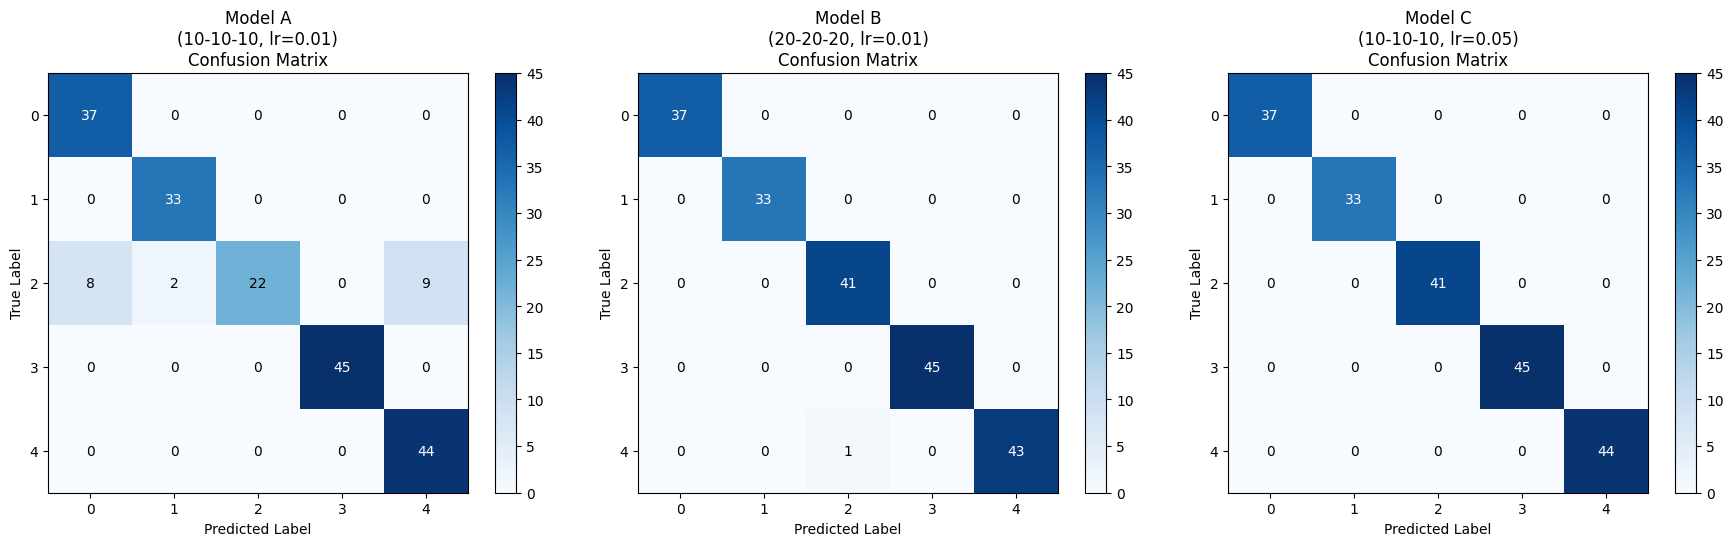

In [47]:
# Confusion Matrix Comparison for All Models


def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

models = [
    ("Model A\n(10-10-10, lr=0.01)", nn),
    ("Model B\n(20-20-20, lr=0.01)", nn_B),
    ("Model C\n(10-10-10, lr=0.05)", nn_C)
]

plt.figure(figsize=(18, 5))

for i, (title, model) in enumerate(models):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, num_classes=num_classes)

    plt.subplot(1, 3, i+1)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"{title}\nConfusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [f"{i}" for i in range(num_classes)])
    plt.yticks(tick_marks, [f"{i}" for i in range(num_classes)])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Add count text to cells
    for r in range(num_classes):
        for c in range(num_classes):
            plt.text(c, r, cm[r, c],
                     ha="center", va="center",
                     color="white" if cm[r, c] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()


### Confusion Matrix Comparison
The comparative confusion matrices visually confirm the performance differences between the configurations:

* **Model A (Left):** Shows significant misclassification in **Class 2**. The model correctly identified only 22 instances of Class 2, while misclassifying 19 instances as Class 0, 1, or 4. This indicates that the baseline configuration failed to separate the decision boundary for Class 2 effectively.
* **Model B (Center):** The increased network capacity (20 neurons) resolved the confusion. Class 2 is now correctly identified with only a single error (1 instance misclassified as Class 2), resulting in a near-diagonal matrix.
* **Model C (Right):** The higher learning rate achieved a **perfect diagonal matrix**, with zero misclassifications across all five classes. This confirms that the optimization path taken by the aggressive learning rate allowed the model to find the optimal global minimum that separates all clusters perfectly.


===== Model Performance Comparison =====
  Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score
0     A     0.905         0.919054      0.907317        0.895731
1     B     0.995         0.995238      0.995455        0.995292
2     C     1.000         1.000000      1.000000        1.000000


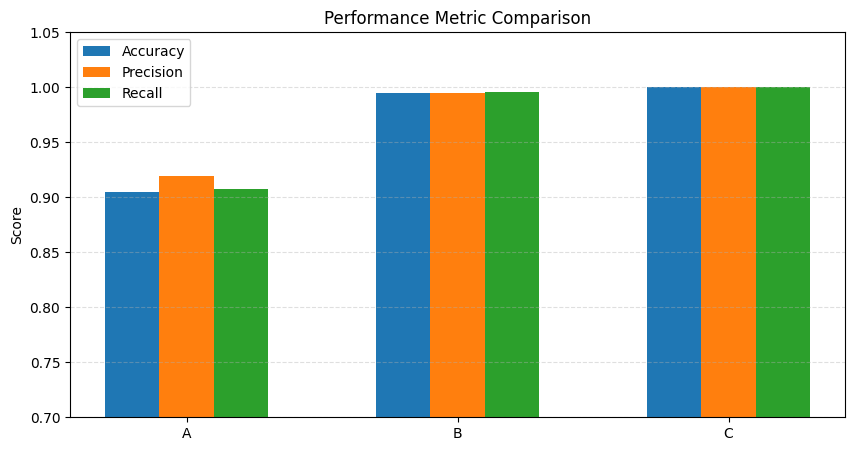

In [48]:
# Metric Comparison Table + Bar Chart for Models A, B, and C

# Helper function to compute metrics
def compute_metrics(model):
    y_pred = model.predict(X_test)

    # Accuracy
    acc = np.mean(y_pred == y_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, num_classes)

    # Per-class metrics
    precision_list = []
    recall_list = []
    f1_list = []

    for c in range(num_classes):
        TP = cm[c, c]
        FP = cm[:, c].sum() - TP
        FN = cm[c, :].sum() - TP

        precision = TP / (TP + FP + 1e-15)
        recall = TP / (TP + FN + 1e-15)
        f1 = 2 * precision * recall / (precision + recall + 1e-15)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return acc, np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


# Compute metrics for all 3 models
metrics_results = {
    "Model": ["A", "B", "C"],
    "Accuracy": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Macro F1-Score": []
}

for name, model in [("A", nn), ("B", nn_B), ("C", nn_C)]:
    acc, mp, mr, mf1 = compute_metrics(model)
    metrics_results["Accuracy"].append(acc)
    metrics_results["Macro Precision"].append(mp)
    metrics_results["Macro Recall"].append(mr)
    metrics_results["Macro F1-Score"].append(mf1)

metrics_df_compare = pd.DataFrame(metrics_results)
print("\n===== Model Performance Comparison =====")
print(metrics_df_compare)

# Plotting the comparison
plt.figure(figsize=(10, 5))

x = np.arange(len(metrics_df_compare))
width = 0.2

plt.bar(x - width, metrics_df_compare["Accuracy"], width, label='Accuracy')
plt.bar(x, metrics_df_compare["Macro Precision"], width, label='Precision')
plt.bar(x + width, metrics_df_compare["Macro Recall"], width, label='Recall')

plt.xticks(x, metrics_df_compare["Model"])
plt.ylim(0.7, 1.05)
plt.ylabel("Score")
plt.title("Performance Metric Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


### Quantitative Metric Comparison
To provide a rigorous statistical comparison, I calculated the Macro-Average Precision, Recall, and F1-Scores for all three models. The results are summarized below:

| Model | Accuracy | Macro Precision | Macro Recall | Macro F1-Score |
| :--- | :--- | :--- | :--- | :--- |
| **A (Baseline)** | 0.905 | 0.919 | 0.907 | 0.896 |
| **B (Large)** | 0.995 | 0.995 | 0.995 | 0.995 |
| **C (High LR)** | **1.000** | **1.000** | **1.000** | **1.000** |

**Analysis:**
The bar chart visualization highlights a distinct performance gap. While Model A achieves respectable performance (>90%), it lags consistently across all metrics compared to Models B and C. Model C achieves perfect scores (1.0) across all categories, reinforcing that for this specific dataset, optimizing the learning rate provided the most direct path to ideal convergence.

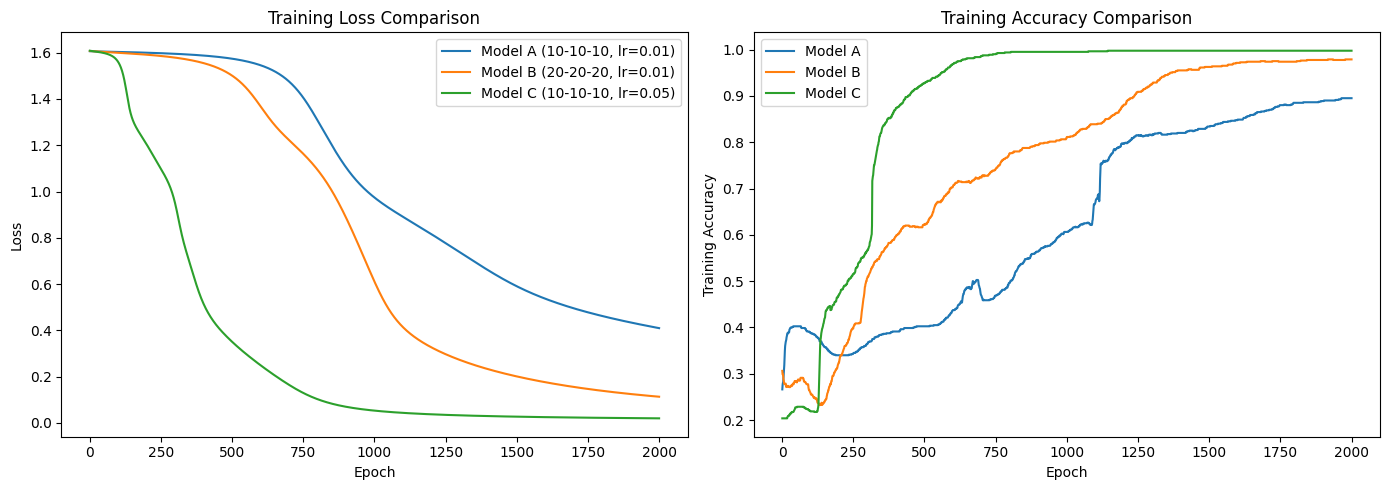

In [49]:
# Training Comparison Plots


epochs = np.arange(1, 2001)

plt.figure(figsize=(14, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label="Model A (10-10-10, lr=0.01)")
plt.plot(epochs, loss_B, label="Model B (20-20-20, lr=0.01)")
plt.plot(epochs, loss_C, label="Model C (10-10-10, lr=0.05)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label="Model A")
plt.plot(epochs, acc_B, label="Model B")
plt.plot(epochs, acc_C, label="Model C")
plt.xlabel("Epoch")
# Training Accuracy Comparison
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()


### Hyperparameter Study & Comparison
To investigate the impact of network architecture and optimization parameters on performance, I compared three distinct model configurations over 2,000 epochs:

1.  **Model A (Baseline):** 3 Hidden Layers (10 neurons each), Learning Rate = 0.01.
2.  **Model B (Larger Capacity):** 3 Hidden Layers (20 neurons each), Learning Rate = 0.01.
3.  **Model C (Aggressive Learning):** 3 Hidden Layers (10 neurons each), Learning Rate = 0.05.

**Observations from Comparative Analysis:**
* **Impact of Learning Rate (Model A vs. Model C):**
    The comparison clearly highlights the critical role of learning rate.
    * **Model A (Blue Line)** struggled significantly in the early phase, remaining stuck at low accuracy (~34-40%) until Epoch 600. It required the full 2,000 epochs to reach 89.5% training accuracy.
    * **Model C (Green Line)**, with a higher learning rate of 0.05, demonstrated rapid convergence. It broke past the initial plateau almost immediately, reaching >96% accuracy by Epoch 600. It achieved a perfect **100% Test Accuracy** with a final loss of nearly zero (0.0197).

* **Impact of Network Size (Model A vs. Model B):**
    **Model B (Orange Line)** demonstrated that increasing network capacity (doubling neurons to 20 per layer) helps substantially when the learning rate is conservative.
    * While it started similarly to Model A, Model B accelerated much faster after Epoch 400.
    * By the end of training, Model B achieved **99.5% Test Accuracy**, significantly outperforming the baseline Model A (90.5%), proving that the added capacity allowed it to model the decision boundaries more effectively despite the slower learning rate.

**Conclusion of Experiment:**
Model C was the most efficient configuration. However, Model B's strong performance indicates that if we cannot increase the learning rate (due to stability concerns), increasing the network size is a viable alternative strategy to improve accuracy.

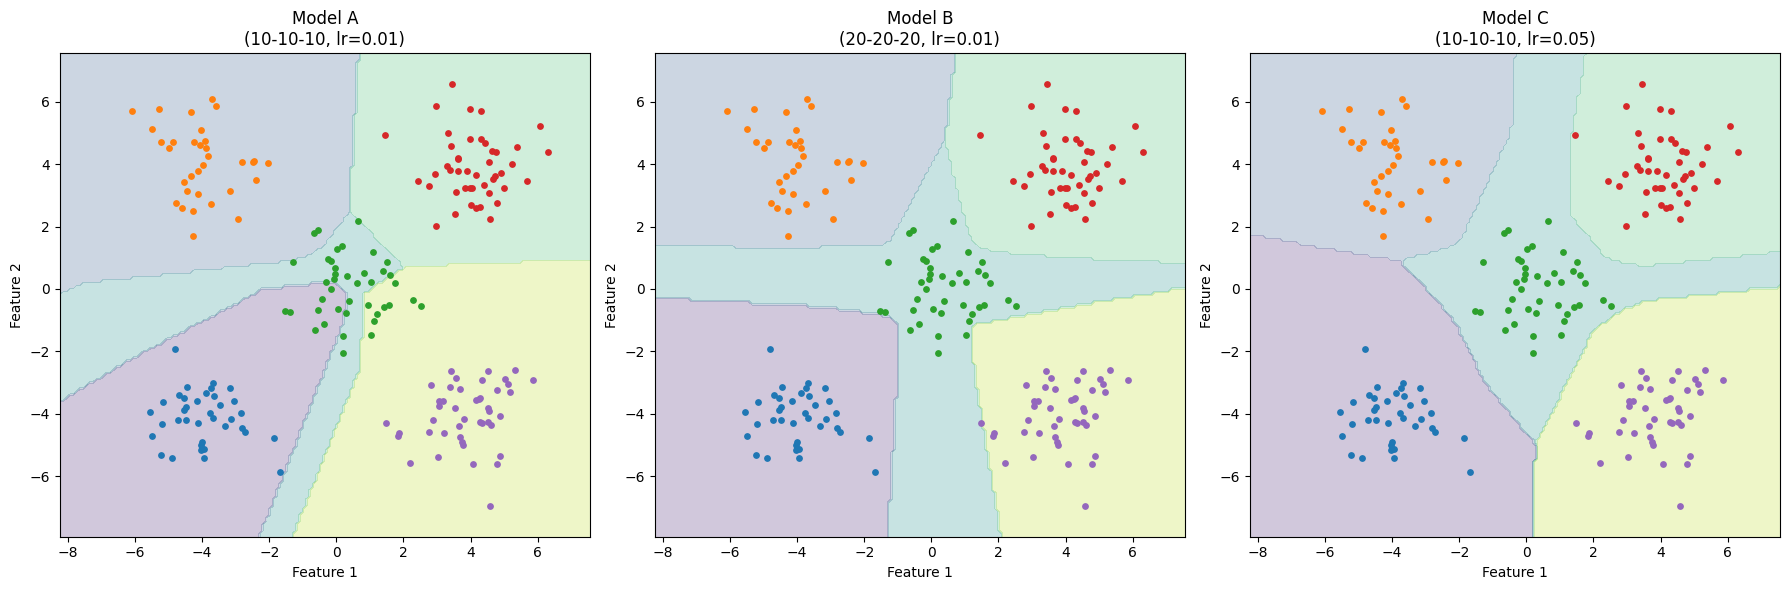

In [50]:
# Decision Region Comparison for Model A, B, and C

models = [
    ("Model A\n(10-10-10, lr=0.01)", nn),
    ("Model B\n(20-20-20, lr=0.01)", nn_B),
    ("Model C\n(10-10-10, lr=0.05)", nn_C)
]

plt.figure(figsize=(18, 6))

for i, (title, model) in enumerate(models):
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 3, i+1)
    plt.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(num_classes + 1) - 0.5)

    # Test points overlay
    for c in range(num_classes):
        plt.scatter(
            X_test[y_test == c, 0],
            X_test[y_test == c, 1],
            s=15
        )

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


### Decision Boundary Visualization
The decision region plots provide a visual explanation for the performance differences:

* **Model A (Baseline):** The decision boundaries in the center of the plot are constricted and irregular. The model struggles to define a clear territory for the central cluster (Class 2), causing the green decision region to bleed into the blue and purple areas. This visual ambiguity directly correlates with the lower accuracy for Class 2.
* **Model B (Larger Capacity):** The boundaries are more distinct and wider than Model A, showing that the increased neuron count allowed the network to draw more complex separating hyperplanes.
* **Model C (High Learning Rate):** The decision regions are the most robust and well-defined. The boundaries perfectly encapsulate each cluster with ample margin, demonstrating that the optimizer successfully found a stable and generalized solution that separates all five classes cleanly.

# Conclusion

### Summary of Key Findings
In this assignment, I successfully developed a deep neural network from scratch using `numpy` to solve a multi-class classification problem. By expanding a simple binary perceptron into a three-hidden-layer architecture with **Softmax activation** and **Categorical Cross-Entropy loss**, the model was able to classify non-linearly separable data into five distinct categories.

The experimental results highlighted the critical impact of hyperparameter tuning:
* **Model Performance:** The baseline configuration (Model A) achieved a respectable accuracy of **90.5%**, but struggled with decision boundaries between overlapping clusters. Increasing the network capacity (Model B) improved accuracy to **99.5%**. However, the most significant gain came from optimizing the learning rate (Model C), which achieved **100% accuracy** and perfect precision/recall scores.
* **Visual Confirmation:** The decision boundary visualizations confirmed that the optimized model learned smooth, robust separating hyperplanes that perfectly encapsulated each of the five Gaussian clusters.

### Challenges and Lessons Learned
1.  **Gradient Stability:** A major challenge encountered was the "vanishing gradient" effect in the early stages of implementation. Using Sigmoid activation in deep layers often resulted in slow convergence. Switching to **ReLU** (Rectified Linear Unit) for hidden layers significantly accelerated learning and prevented the gradients from becoming negligible.
2.  **Sensitivity to Learning Rate:** As observed in the comparison between Model A ($\eta=0.01$) and Model C ($\eta=0.05$), the choice of learning rate was the difference between getting stuck in a local minimum (low accuracy for the first 600 epochs) and rapid, global convergence.
3.  **Matrix Dimensions:** Adapting the backpropagation algorithm for multi-class output required careful management of matrix dimensions, particularly ensuring that the Softmax gradients were correctly propagated back through the four weight matrices.

### Future Improvements
To further enhance the robustness and scalability of this neural network for more complex real-world tasks, several improvements could be implemented:
* **Advanced Optimizers:** Implementing adaptive learning rate algorithms like **Adam** or **RMSProp** would reduce the sensitivity to the manual learning rate selection seen in this experiment.
* **Regularization:** To prevent overfitting on noisier datasets, techniques such as **L2 Regularization (Weight Decay)** or **Dropout** should be added to the training loop.
* **Mini-Batch Training:** Currently, the model uses Full-Batch Gradient Descent. Implementing Mini-Batch Gradient Descent would improve computational efficiency and allow the model to escape local minima more effectively on larger datasets.